In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

# Data Collection and Preparation

In [3]:
original = pd.read_csv("../data/BankChurners.csv")
balance_df = pd.read_csv("../data/botswana_bank_customer_churn.csv")
technical_df = pd.read_csv("../data/User churn.csv")

sav = pd.read_csv("../data/credit_score.csv") 
# https://www.kaggle.com/datasets/conorsully1/credit-score?resource=download

campaign = pd.read_csv("../data/campaign_data.csv", sep = ';')
# https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets?select=test.csv
# training data was used since it was much larger than test data (randomly selected rows from training data)

In [4]:
# removing irrelevent columns
original = original.drop(original.columns[[-1, -2]], axis=1)
original = original.drop(columns=['Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Contacts_Count_12_mon','Total_Ct_Chng_Q4_Q1'])

# renaming the datasets
original = original.rename(columns={'Months_on_book' : 'Month_with_bank',
                                    'Total_Relationship_Count' : 'No_of_product',
                                    'Total_Trans_Ct' : 'Total_Trans_Count'})

# removing Na from the dataset
original_Unknown = original[original.isin(['Unknown']).any(axis=1)] # someone handle the unknown please
original = original[~original.isin(['Unknown']).any(axis=1)]


In [5]:
# this function will remove the k,$ and + sign in the income category column
def clean_col(x):
        if 'K' in x:
            return x.replace('K','').replace('$','')
        elif '+' in x:
            return x.replace('+','')
        elif x =='Less than 40':
            return x.split()[2]
        return x
    
original['Income_Category']=original['Income_Category'].apply(clean_col)

In [6]:
# Converting object into category
categorical_features = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
for category in categorical_features:
    original[category] = original[category].astype('category')

## Synthetic data 

### 1 Balance dataset

Adding in  `Credit Score`,`Outstanding Loans`, `Balance` from balance dataset. The final dataframe is stored as `final_df`

#### 1.1 Feature selection

In [7]:
# subsetting from the original data
required_features = ["CLIENTNUM","Customer_Age","Gender","Income_Category","No_of_product"]
subset_original = original.loc[:,required_features]

# subsetting from the income data
required_features2 = ['Date of Birth','Gender','Income','NumOfProducts','Credit Score','Outstanding Loans', 'Balance']
subset_balance = balance_df.loc[:,required_features2]

#### 1.2 Data Cleaning

In [8]:
# Changing date of birth to date time and them convert it to age
subset_balance['Date of Birth'] = pd.to_datetime(subset_balance['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
subset_balance['Date of Birth'] = reference_date.year - subset_balance['Date of Birth'].dt.year

# Changing income into income category
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
subset_balance['Income'] = pd.cut(subset_balance['Income'], bins=bins, labels=labels, right=False)

# Recoding Male to M...
subset_balance['Gender'] = subset_balance['Gender'].replace({'Male':'M','Female':'F'})

# Renaming the balance_subset dataframe
subset_balance = subset_balance.rename(columns = {'Date of Birth' : "Customer_Age", 
                                        'Income' : "Income_Category", 'NumOfProducts' : "No_of_product"})

# Converting object to category
subset_balance['Gender'] = subset_balance['Gender'].astype('category')

#### 1.3 Data Transformation

In [9]:
#Scaling 
scaler = MinMaxScaler()
subset_balance[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_balance[['Customer_Age','No_of_product']])
subset_original[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_original[['Customer_Age','No_of_product']])

# Encode the categorical variables
le_gender = LabelEncoder()
subset_balance['Gender_Encoded'] = le_gender.fit_transform(subset_balance['Gender'])
subset_original['Gender_Encoded'] = le_gender.fit_transform(subset_original['Gender'])

le_income = LabelEncoder()
subset_balance['Income_Category_Encoded'] = le_income.fit_transform(subset_balance['Income_Category'])
subset_original['Income_Category_Encoded'] = le_income.fit_transform(subset_original['Income_Category'])

# Extract relevant features for clustering
features_balance = subset_balance[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]
features_original = subset_original[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]

#### 1.4 Model Training

In [10]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range = range(2, 7)  # Define the range of cluster numbers to test
inertia_values = []  # Inertia will help determine the optimal cluster number

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans.fit(features_balance)
    inertia_values.append(kmeans.inertia_)

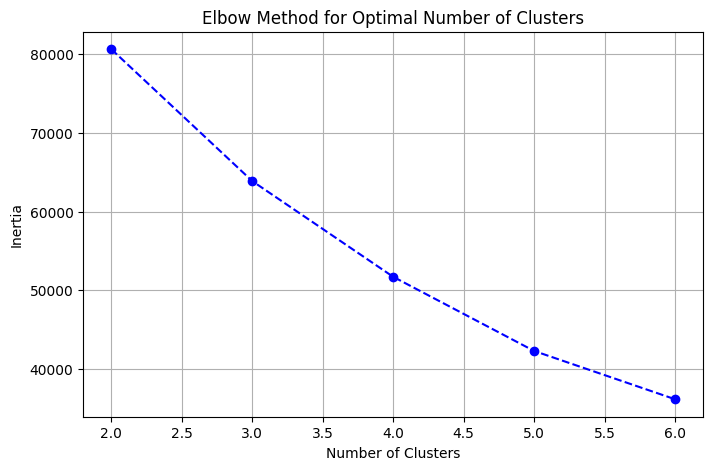

In [11]:
# Plot the elbow method to determine the best cluster count
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [12]:
# Fit the final KMeans model with the selected number of clusters
optimal_k = 5  # Choosen based on the elbow plot
kmeans_final = KMeans(n_clusters=optimal_k, random_state=3101, n_init = 10)
kmeans_final.fit(features_balance)
subset_balance['Cluster_Labels'] = kmeans_final.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original['Cluster_Labels'] = kmeans_final.predict(features_original)

In [13]:
# List of target variables
target_columns = ['Credit Score','Outstanding Loans', 'Balance']

# Dictionary to hold fitted parameters (mean, std) for each cluster and each target variable
cluster_params = {}

for target in target_columns:
    cluster_params[target] = {}
    # Group by clusters
    for cluster in subset_balance['Cluster_Labels'].unique():
        cluster_data = subset_balance[subset_balance['Cluster_Labels'] == cluster][target]
        # Fit a normal distribution to the data in the cluster
        mean, std = norm.fit(cluster_data)
        cluster_params[target][cluster] = (mean, std)

In [14]:
# Create a function to draw samples based on the cluster label using CLIENTNUM
def generate_synthetic_data_with_clientnum(base_data, cluster_params, target):
    # Initialize a dictionary for storing CLIENTNUM and synthetic values
    synthetic_values = {}
    
    # Iterate over each record in the base data
    for idx, row in base_data.iterrows():
        clientnum = row['CLIENTNUM']  # Fetch the unique identifier
        cluster_label = row['Cluster_Labels']  # Assuming cluster labels are already assigned to base data
        mean, std = cluster_params[target][cluster_label]
        
        # Draw a sample from the normal distribution
        synthetic_value = norm.rvs(loc=mean, scale=std)
        
        # Store the synthetic value with CLIENTNUM as the key
        synthetic_values[clientnum] = synthetic_value
    
    return synthetic_values

# Generate synthetic data for each target variable in the original subset
for target in target_columns:
    synthetic_data = generate_synthetic_data_with_clientnum(subset_original, cluster_params, target)
    
    # Add the synthetic data to the original subset using CLIENTNUM as the identifier
    subset_original[f'{target}'] = subset_original['CLIENTNUM'].map(synthetic_data)

### 2 Technical dataset

This section aims to generate artificial data for digital engagement.

#### 2.1 Feature Selection

In [15]:
required_features_original = ['CLIENTNUM', 'Gender', 'Customer_Age', 'Marital_Status', 'Dependent_count', 'Attrition_Flag']
subset_original2 = original.loc[:,required_features_original]

required_features_tech = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Churn',
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']
subset_technical = technical_df.loc[:,required_features_tech]

#### 2.2 Data Cleaning

In [16]:
subset_original2['SeniorCitizen'] = (subset_original2['Customer_Age'] > 60).astype(int)
subset_original2['Dependents'] = subset_original2['Dependent_count'].apply(lambda x: 'Yes' if x > 0 else 'No')

subset_original2.drop(['Customer_Age', 'Dependent_count'], axis = 1, inplace = True)

subset_technical['gender'] = subset_technical['gender'].replace({'Male':'M','Female':'F'})
subset_technical['Churn'] = subset_technical['Churn'].replace({'Attrited Customer':'Yes','Existing Customer':'No'})
subset_technical['Partner'] = subset_technical['Partner'].replace({'Married':'Yes','Single':'No'})

subset_technical = subset_technical.rename(columns = {'gender' : "Gender", 'Churn' : "Attrition_Flag", 'Partner' : "Marital_Status"})

#### 2.3 Data Transformation

In [17]:
from sklearn.preprocessing import LabelEncoder

# List of categorical features
modified_features_tech = ['Gender', 'SeniorCitizen', 'Marital_Status', 'Dependents', 'Attrition_Flag', 
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']

# Initialize dictionaries to store encodings
encodings_technical = {}
encodings_original2 = {}

# Encoding for subset_technical
for feature in modified_features_tech:
    # Convert to category type
    subset_technical[feature] = subset_technical[feature].astype('category')
    if feature in subset_original2:
        subset_original2[feature] = subset_original2[feature].astype('category')

# Apply LabelEncoder and show mappings
for feature in modified_features_tech:
    le_technical = LabelEncoder()
    
    # Fit and transform for subset_technical
    subset_technical[feature + '_Encoded'] = le_technical.fit_transform(subset_technical[feature])
    
    # Store the mapping for subset_technical
    encodings_technical[feature] = dict(zip(le_technical.classes_, le_technical.transform(le_technical.classes_)))
    
    # If feature exists in subset_original2, apply encoding
    if feature in subset_original2:
        le_original2 = LabelEncoder()
        subset_original2[feature + '_Encoded'] = le_original2.fit_transform(subset_original2[feature])
        
        # Store the mapping for subset_original2
        encodings_original2[feature] = dict(zip(le_original2.classes_, le_original2.transform(le_original2.classes_)))

features_original2 = subset_original2[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
features_technical = subset_technical[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
# Display the encoding mappings
print("Encodings for subset_technical:")
for feature, mapping in encodings_technical.items():
    print(f"{feature}: {mapping}")

print("\nEncodings for subset_original2:")
for feature, mapping in encodings_original2.items():
    print(f"{feature}: {mapping}")

Encodings for subset_technical:
Gender: {'F': 0, 'M': 1}
SeniorCitizen: {0: 0, 1: 1}
Marital_Status: {'No': 0, 'Yes': 1}
Dependents: {'No': 0, 'Yes': 1}
Attrition_Flag: {'No': 0, 'Yes': 1}
PhoneService: {'No': 0, 'Yes': 1}
InternetService: {'DSL': 0, 'Fiber optic': 1, 'No': 2}
TechSupport: {'No': 0, 'No internet service': 1, 'Yes': 2}
PaperlessBilling: {'No': 0, 'Yes': 1}
PaymentMethod: {'Bank transfer (automatic)': 0, 'Credit card (automatic)': 1, 'Electronic check': 2, 'Mailed check': 3}

Encodings for subset_original2:
Gender: {'F': 0, 'M': 1}
SeniorCitizen: {0: 0, 1: 1}
Marital_Status: {'Divorced': 0, 'Married': 1, 'Single': 2}
Dependents: {'No': 0, 'Yes': 1}
Attrition_Flag: {'Attrited Customer': 0, 'Existing Customer': 1}


#### 2.4 Model Training

In [18]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range2 = range(2, 10)  # Define the range of cluster numbers to test
inertia_values2 = []  # Inertia will help determine the optimal cluster number

for k in cluster_range2:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans.fit(features_technical)
    inertia_values2.append(kmeans.inertia_)

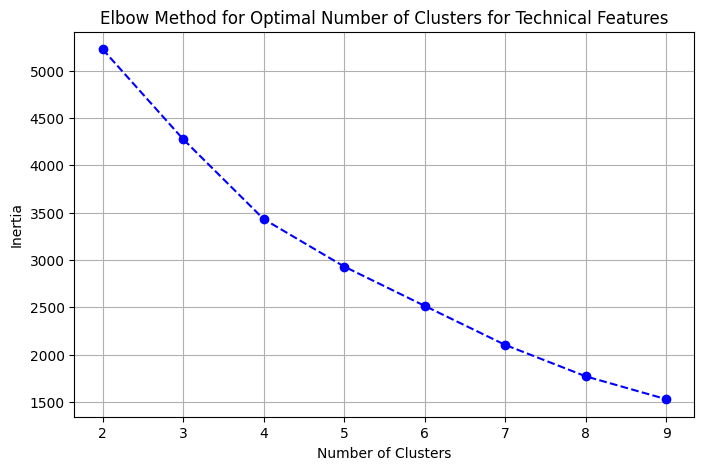

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range2, inertia_values2, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters for Technical Features')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [20]:
# Fit the final KMeans model with the selected number of clusters
optimal_k_technical = 5  # Choosen based on the elbow plot
kmeans_technical = KMeans(n_clusters=optimal_k, random_state=3101, n_init = 10)
kmeans_technical.fit(features_technical)
subset_technical['Cluster_Labels'] = kmeans_technical.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original2['Cluster_Labels'] = kmeans_technical.predict(features_original2)

In [21]:
# Calculate the distribution of PhoneService
phone_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['PhoneService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of InternetService
internet_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['InternetService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of TechSupport
tech_support_distribution = (
    subset_technical.groupby('Cluster_Labels')['TechSupport_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaperlessBilling
paperless_billing_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaperlessBilling_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaymentMethod
payment_method_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaymentMethod_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

In [22]:
def generate_synthetic_features(df, distribution):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        cluster = row['Cluster_Labels']
        
        # Sample a new feature based on the defined probabilities
        sample = np.random.choice(
            distribution.columns,  # Possible features to sample from
            p=distribution.loc[cluster].values  # Probabilities for the respective features
        )
        synthetic_feature.append(sample)
            
    return synthetic_feature

# Generate synthetic features
subset_original2['PhoneService'] = generate_synthetic_features(subset_original2, phone_service_distribution)
subset_original2['InternetService'] = generate_synthetic_features(subset_original2, internet_service_distribution)
subset_original2['TechSupport'] = generate_synthetic_features(subset_original2, tech_support_distribution)
subset_original2['PaperlessBilling'] = generate_synthetic_features(subset_original2, paperless_billing_distribution)
subset_original2['PaymentMethod'] = generate_synthetic_features(subset_original2, payment_method_distribution)

##### Final synthetic dataframe

In [23]:
# Making the final segmentation data for actual segmentation

# Feature from original dataset
feature_from_original = ['CLIENTNUM','Income_Category','No_of_product',
                         'Total_Trans_Amt', 'Total_Trans_Count']
temp1 = original.loc[:,feature_from_original]

# Feature from balance
final_balance_features = ['CLIENTNUM','Credit Score',
       'Outstanding Loans', 'Balance']
temp2 = subset_original.loc[:,final_balance_features]

# Feature from technical
final_tech_features = ['CLIENTNUM','PhoneService','InternetService','TechSupport','PaperlessBilling','PaymentMethod']
temp3  = subset_original2.loc[:,final_tech_features]


# Joingning them all together
temp4 = pd.merge(temp1, temp2, on='CLIENTNUM', how='inner')
final_df = pd.merge(temp4, temp3, on='CLIENTNUM', how = 'inner')

### 3 Credit Score dataset

for `Savings`

In [24]:
original_copy = original.copy()

# convert income into income category then one-hot encoding
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
sav['Income_Category'] = pd.cut(sav['INCOME'], bins = bins, labels = labels, right = False)
sav = pd.get_dummies(sav, columns=['Income_Category'], drop_first=True)

# clustering
features = sav[['Income_Category_40 - 60', 'Income_Category_60 - 80', 'Income_Category_80 - 120', 'Income_Category_120 +']]

kmeans = KMeans(n_clusters = 5, n_init = 10)
sav['Cluster'] = kmeans.fit_predict(features)

# fitting normal distribution
stats = sav.groupby('Cluster')['SAVINGS'].agg(['mean', 'std']).reset_index()
stats.columns = ['Cluster', 'Mean', 'SD']

def sample(cluster):
    mean = stats.loc[stats['Cluster'] == cluster, 'Mean'].values[0]
    sd = stats.loc[stats['Cluster'] == cluster, 'SD'].values[0]
    return round(max(np.random.normal(mean, sd), 0), 2) #avoid savings being negative & change to 2 decimal places

sav['Savings'] = sav['Cluster'].apply(sample)

# fitting into original
original_copy = pd.get_dummies(original_copy, columns=['Income_Category'], drop_first = False)
original_copy['Cluster'] = kmeans.predict(original_copy[['Income_Category_40 - 60', 'Income_Category_60 - 80', 'Income_Category_80 - 120', 'Income_Category_120 +']])
original_copy['Savings'] = original_copy['Cluster'].apply(sample)
original['Savings'] = original_copy['Savings']

### 4 Campaign data

In [25]:
campaign.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [26]:
# similar columns: education, marital, age
common_features = ['education', 'marital', 'age']

ori = original.copy()
ori['education'] = ori['Education_Level']
ori['education'] = ori['education'].replace(
    {'Doctorate': 'tertiary',
     'Post-Graduate': 'tertiary',
     'Graduate': 'tertiary',
     'College': 'secondary',
     'High School': 'secondary', 
     'Uneducated': 'primary'})

ori['marital'] = ori['Marital_Status']
ori['marital'] = ori['marital'].replace(
    {'Married': 'married',
     'Single': 'single',
     'Divorced': 'divorced'})

ori['age'] = ori['Customer_Age']

Data that will be added:
- `duration`: last contact duration, in seconds (numeric) --> `Duration_of_Contact`
- `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact) --> `Number_of_Contacts_Made`
- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted) --> `Last_Contact_Made`
- `y`: has the client subscribed a term deposit? (binary: "yes","no") --> `Outcome`

In [27]:
# d/b of duration
duration_db = (
    campaign.groupby(common_features)['duration']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of campaign
campaign_db = (
    campaign.groupby(common_features)['campaign']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of pdays
pdays_db = (
    campaign.groupby(common_features)['pdays']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of y
campaign['y'] = campaign['y'].replace({'yes': 1, 'no': 0})
y_db = (
    campaign.groupby(common_features)['y']
    .mean()
    .reset_index()
)

In [28]:
# generating synthetic features
def generate_synthetic_features(df, distribution, feature):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        features = tuple(row[common_features])
        try:
            sample = np.random.choice(
                distribution.columns,
                p=distribution.loc[features].values
            )
        except KeyError: #incase the feature combination is missing
            sample = np.random.choice(distribution.columns)
            
        synthetic_feature.append(sample)
            
    return synthetic_feature

def generate_synthetic_outcome(df, distribution):
    synthetic_outcome = []
    
    for _, row in df.iterrows():
        features = tuple(row[common_features])
        matching_row = distribution.loc[(distribution[common_features] == features).all(axis=1)]
        
        if not matching_row.empty:
            prob_yes = matching_row['y'].values[0]
            sample = np.random.choice([0, 1], p=[1 - prob_yes, prob_yes])
        else:
            sample = np.random.choice([0, 1])
        
        synthetic_outcome.append(sample)
    
    return synthetic_outcome

# generating the data
np.random.seed(10)
original['Duration_of_Contact'] = generate_synthetic_features(ori, duration_db, 'duration')
original['Num_of_Contacts_Made'] = generate_synthetic_features(ori, campaign_db, 'campaign')
original['Last_Contacted'] = generate_synthetic_features(ori, pdays_db, 'pdays')
original['Outcome'] = generate_synthetic_outcome(ori, y_db)
original.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Count,Avg_Utilization_Ratio,Savings,Duration_of_Contact,Num_of_Contacts_Made,Last_Contacted,Outcome
0,768805383,Existing Customer,45,M,3,High School,Married,60 - 80,Blue,39,...,12691.0,777,1144,42,0.061,414367.81,304,1,-1,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40,Blue,44,...,8256.0,864,1291,33,0.105,252203.55,35,1,-1,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,80 - 120,Blue,36,...,3418.0,0,1887,20,0.000,0.00,209,2,-1,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60 - 80,Blue,21,...,4716.0,0,816,28,0.000,180421.94,327,1,-1,1
5,713061558,Existing Customer,44,M,2,Graduate,Married,40 - 60,Blue,36,...,4010.0,1247,1088,24,0.311,511950.08,157,7,-1,0


# Subgroup A: Customer Segmentation and Behaviour Analysis

## 1. How can we effectively segment our customers based on their banking behavior and preferences?
### Develop a customer segmentation model using the collected data.

### Feature Engineering Rules

#### 1. Digital Engagement
We will combine the following features to create the `Digital_Engagement` score:
- **PhoneService**: If the customer has phone service (`PhoneService = 1`), add 1 point.
- **InternetService**: 
  - If the customer has **Fiber optic internet** (`InternetService = 1`), add 2 points.
  - If **DSL** (`InternetService = 0`), add 1 point.
- **TechSupport**: 
  - If the customer uses tech support (`TechSupport = 2`), add 2 points.
  - If no tech support (`TechSupport = 0`), add 0 points.
- **PaperlessBilling**: If the customer has paperless billing (`PaperlessBilling = 1`), add 1 point.
- **PaymentMethod**: 
  - If the customer uses **automatic payments** (`PaymentMethod = 0 or 1`), add 2 points.
  - If **electronic check** (`PaymentMethod = 2`), add 1 point.

**Total score range**: 0 to 8 (where 0 means low engagement and 8 means high engagement).

---

#### 2. Financial Status
We will combine the following features to create the `Financial_Status` score:
- **Income_Category**: 
  - If the customer has income in the range `80 - 120` or higher (`120 +`), add 2 points.
  - If `40 - 60`, add 1 point.
- **Credit Score**: 
  - If the credit score is above 700, add 2 points.
  - If between 600 and 700, add 1 point.
- **Outstanding Loans**: 
  - If the loans are less than $20,000, add 2 points.
  - If loans are between $20,000 and $50,000, add 1 point.
- **Balance**: 
  - If the balance is higher than $100,000, add 2 points.
  - If balance is between $50,000 and $100,000, add 1 point.

**Total score range**: 0 to 8 (higher means stronger financial status).

---

#### 3. Transaction Behavior
We will create a composite score for `Transaction_Behavior`:
- **Total_Trans_Amt**: 
  - If the total transaction amount is in the top 25%, add 2 points.
  - If in the middle 50%, add 1 point.
- **Total_Trans_Count**: 
  - If the total number of transactions is in the top 25%, add 2 points.
  - If in the middle 50%, add 1 point.

**Total score range**: 0 to 4 (higher means frequent and high-value transactions).

---

#### 4. Product Usage
We will categorize customers based on the number of products they use and assign them a `Product_Usage` label:
- **Heavy User**: Customers using more than 3 products.
- **Moderate User**: Customers using 2-3 products.
- **Light User**: Customers using 1 product.

In [29]:
### 1. Digital Engagement Score ###
def digital_engagement(row):
    score = 0
    # PhoneService
    if row['PhoneService'] == 1:
        score += 1
    # InternetService
    if row['InternetService'] == 1:  # Fiber optic
        score += 2
    elif row['InternetService'] == 0:  # DSL
        score += 1
    # TechSupport
    if row['TechSupport'] == 2:
        score += 2
    # PaperlessBilling
    if row['PaperlessBilling'] == 1:
        score += 1
    # PaymentMethod
    if row['PaymentMethod'] in [0, 1]:  # Bank transfer or Credit card (automatic)
        score += 2
    elif row['PaymentMethod'] == 2:  # Electronic check
        score += 1
    return score

### 2. Financial Status Score ###
def financial_status(row):
    score = 0
    # Income_Category
    if row['Income_Category'] in ['80 - 120', 'Other']:
        score += 2
    elif row['Income_Category'] == '40 - 60':
        score += 1
    # Credit Score
    if row['Credit Score'] > 700:
        score += 2
    elif 600 <= row['Credit Score'] <= 700:
        score += 1
    # Outstanding Loans
    if row['Outstanding Loans'] < 20000:
        score += 2
    elif 20000 <= row['Outstanding Loans'] < 50000:
        score += 1
    # Balance
    if row['Balance'] > 100000:
        score += 2
    elif 50000 <= row['Balance'] <= 100000:
        score += 1
    return score

### 3. Transaction Behavior Score ###
def transaction_behavior(df, amt_feature, count_feature):
    # Precompute the quantiles for the given transaction amount and count features
    trans_amt_quantiles = df[amt_feature].quantile([0.25, 0.75])
    trans_count_quantiles = df[count_feature].quantile([0.25, 0.75])
    
    def calculate_score(row):
        score = 0
        # Total_Trans_Amt
        if row[amt_feature] > trans_amt_quantiles[0.75]:
            score += 2
        elif row[amt_feature] > trans_amt_quantiles[0.25]:
            score += 1
        # Total_Trans_Count
        if row[count_feature] > trans_count_quantiles[0.75]:
            score += 2
        elif row[count_feature] > trans_count_quantiles[0.25]:
            score += 1
        return score
    
    # Apply the score calculation function to the dataframe
    df['Transaction_Behavior'] = df.apply(calculate_score, axis=1)
    
    return df

### 4. Product Usage ###
def product_usage(row):
    if row['No_of_product'] > 4:
        return 'Heavy User'
    elif 2 <= row['No_of_product'] >= 4:
        return 'Moderate User'
    else:
        return 'Light User'

### Feature Integration: Banking Behavior and Customer Preferences

#### 1. **Banking Behavior**
- **Transaction Behavior**: 
  - Combines total transaction amount and count.
  - High transaction behavior receives a higher score.
  
- **Product Usage**:
  - If the customer is a **Heavy User** of products, they get an additional 2 points.
  - **Moderate Users** get 1 point.
  - **Light Users** don’t add any points.
  
#### 2. **Customer Preferences**
- **Digital Engagement**:
  - Captures how much the customer engages with the bank's digital services.
  - Score based on PhoneService, InternetService, TechSupport, PaperlessBilling, and PaymentMethod.
  
- **Financial Status**:
  - Measures the customer’s financial health based on income, credit score, outstanding loans, and balance.
  
The final **Customer Preferences Score** is the sum of **Digital Engagement** and **Financial Status**.

In [30]:
# Function to combine the individual features into two composite features

def integrate_banking_behavior(row):
    # Combine Transaction Behavior and Product Usage
    banking_behavior_score = row['Transaction_Behavior']
    
    if row['Product_Usage'] == 'Heavy User':
        banking_behavior_score += 2
    elif row['Product_Usage'] == 'Moderate User':
        banking_behavior_score += 1
    # Light users don't add extra points to the banking behavior score
    
    return banking_behavior_score

def integrate_customer_preferences(row):
    # Combine Digital Engagement and Financial Status
    customer_preferences_score = row['Digital_Engagement'] + row['Financial_Status']
    
    return customer_preferences_score


In [31]:
final_df['Digital_Engagement'] = final_df.apply(digital_engagement, axis=1)
final_df['Financial_Status'] = final_df.apply(financial_status, axis=1)
final_df = transaction_behavior(final_df, 'Total_Trans_Amt', 'Total_Trans_Count')
final_df['Product_Usage'] = final_df.apply(product_usage, axis=1)

# Apply the new functions to the dataframe
final_df['Banking_Behavior'] = final_df.apply(integrate_banking_behavior, axis=1)
final_df['Customer_Preferences'] = final_df.apply(integrate_customer_preferences, axis=1)

### Identify unique characteristics and needs for each customer segment.
### Rule-Based Segmentation Based on Banking Behavior and Customer Preferences

#### Classification Ranges:
- **Banking Behavior**:
  - **Low (L)**: Score < 3
  - **Moderate (M)**: Score 3–4(inclusive)
  - **High (H)**: Score > 4

- **Customer Preferences**:
  - **Low (L)**: Score < 6
  - **Moderate (M)**: Score 6–11(inclusive)
  - **High (H)**: Score > 11

#### Segments:

1. **Low Engagement, Low Banking Behavior**:
   - **Banking Behavior**: Low (Score < 3)
   - **Customer Preferences**: Low (Score < 6)
   - **Business Insight**: These customers are disengaged both digitally and financially. Focus on retention through educational programs and targeted basic financial offerings.

2. **Highly Engaged, High Banking Behavior**:
   - **Banking Behavior**: High (Score > 4)
   - **Customer Preferences**: High (Score > 11)
   - **Business Insight**: These customers are highly engaged both financially and digitally. They should be prioritized for premium services, loyalty programs, and personalized offers.

3. **High Engagement, Low or Moderate Banking Behavior**:
   - **Banking Behavior**: Low (Score < 3) or Moderate (Score 3–4)
   - **Customer Preferences**: High (Score > 11)
   - **Business Insight**: These customers are digitally engaged but lack full financial activity. Focus on cross-selling financial products to increase their banking engagement.

4. **High Banking Behavior, Low or Moderate Engagement**:
   - **Banking Behavior**: High (Score > 4)
   - **Customer Preferences**: Low (Score < 6) or Moderate (Score 6–10)
   - **Business Insight**: These customers are financially active but have lower digital engagement. Promote online services or mobile banking to increase digital activity.

5. **Moderate or Low Engagement and Banking Behavior**:
   - **Banking Behavior**: Moderate (Score 3–4) or Low (Score < 3)
   - **Customer Preferences**: Moderate (Score 6–10) or Low (Score < 6)
   - **Business Insight**: These customers have limited engagement both financially and digitally. Focus on retention strategies and encouraging digital services and basic financial products.

In [32]:
# Function to assign clusters based on Banking Behavior and Customer Preferences with thresholds as arguments
def assign_rule_based_cluster(row, banking_thresholds, customer_thresholds):
    banking_low, banking_moderate = banking_thresholds
    customer_low, customer_moderate = customer_thresholds
    
    # Rule 1: Low Engagement, Low Banking Behavior
    if row['Banking_Behavior'] < banking_low and row['Customer_Preferences'] < customer_low:
        return 'Low Engagement, Low Banking Behavior'
    
    # Rule 2: Highly Engaged, High Banking Behavior
    elif row['Banking_Behavior'] > banking_moderate and row['Customer_Preferences'] > customer_moderate:
        return 'Highly Engaged, High Banking Behavior'
    
    # Rule 3: High Engagement, Low or Moderate Banking Behavior
    elif row['Banking_Behavior'] <= banking_moderate and row['Customer_Preferences'] > customer_moderate:
        return 'High Engagement, Low or Moderate Banking Behavior'
    
    # Rule 4: High Banking Behavior, Low or Moderate Engagement
    elif row['Banking_Behavior'] > banking_moderate and row['Customer_Preferences'] <= customer_moderate:
        return 'High Banking Behavior, Low or Moderate Engagement'
    
    # Rule 5: Moderate or Low Engagement and Banking Behavior
    elif row['Banking_Behavior'] <= banking_moderate and row['Customer_Preferences'] <= customer_moderate:
        return 'Moderate or Low Engagement and Banking Behavior'
    
    # Default case: If no specific rule is met
    return 'Other'


In [33]:
banking_thresholds = (3, 4)  # (Low, Moderate)
customer_thresholds = (6, 11)  # (Low, Moderate)

# Apply the function to create the 'Cluster_Labels' column
final_df['Cluster_Labels'] = final_df.apply(assign_rule_based_cluster, axis=1, 
                                            banking_thresholds=banking_thresholds, 
                                            customer_thresholds=customer_thresholds)

# Display the cluster distribution
final_df['Cluster_Labels'].value_counts()

Cluster_Labels
Moderate or Low Engagement and Banking Behavior      5637
High Banking Behavior, Low or Moderate Engagement     637
High Engagement, Low or Moderate Banking Behavior     583
Low Engagement, Low Banking Behavior                  159
Highly Engaged, High Banking Behavior                  65
Name: count, dtype: int64

## 2. What are the key factors influencing customer engagement with our marketing campaigns?
### Analyze historical campaign data to identify main drivers of engagement.

In [34]:
# merging final_df and original
# common columnns:
cols = ['CLIENTNUM', 'Income_Category', 'No_of_product', 'Total_Trans_Amt', 'Total_Trans_Count']
original = original.merge(final_df, on = cols, how = 'inner')

In [35]:
outcome_counts = original['Outcome'].value_counts(normalize = True) * 100

success_percentage = outcome_counts.get(1, 0)
failure_percentage = outcome_counts.get(0, 0)

# Display the percentages
print(f"Success Rate: {success_percentage:.2f}%")
print(f"Failure Rate: {failure_percentage:.2f}%")

Success Rate: 12.22%
Failure Rate: 87.78%


In [36]:
ori = original.copy()
cols_to_std = ['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']
ori[cols_to_std] = (ori[cols_to_std] - ori[cols_to_std].mean()) / ori[cols_to_std].std()
ori[['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']].corr()

,Duration_of_Contact,Num_of_Contacts_Made,Outcome
Duration_of_Contact,1.000000,0.133918,0.069756
Num_of_Contacts_Made,0.133918,1.000000,0.100823
Outcome,0.069756,0.100823,1.000000


The correlation matrix does not show high correlation between Outcome and any other variable. The highest positive correlation is between Outcome and Number of Contacts Made.

All the correlations are positive which means an increase in the duration of the contact or number of contacts made could result in an increase in outcome.

The reasons why the correlations are so low is because the number of successful campaigns is low.

Lets observe the correlation with other variables.

In [37]:
# observing correlation of selected columns & standardising numerical variables
# standardising numerical columns
num_cols_to_std = ['Customer_Age', 'Month_with_bank', 'No_of_product', 'Credit_Limit', 'Total_Trans_Amt'
                   , 'Total_Trans_Count', 'Savings', 'Credit Score'
                   , 'Balance', 'PaymentMethod'
                   , 'Transaction_Behavior', 'Banking_Behavior', 'Outcome']
ori[num_cols_to_std] = (ori[num_cols_to_std] - ori[num_cols_to_std].mean()) / ori[num_cols_to_std].std()

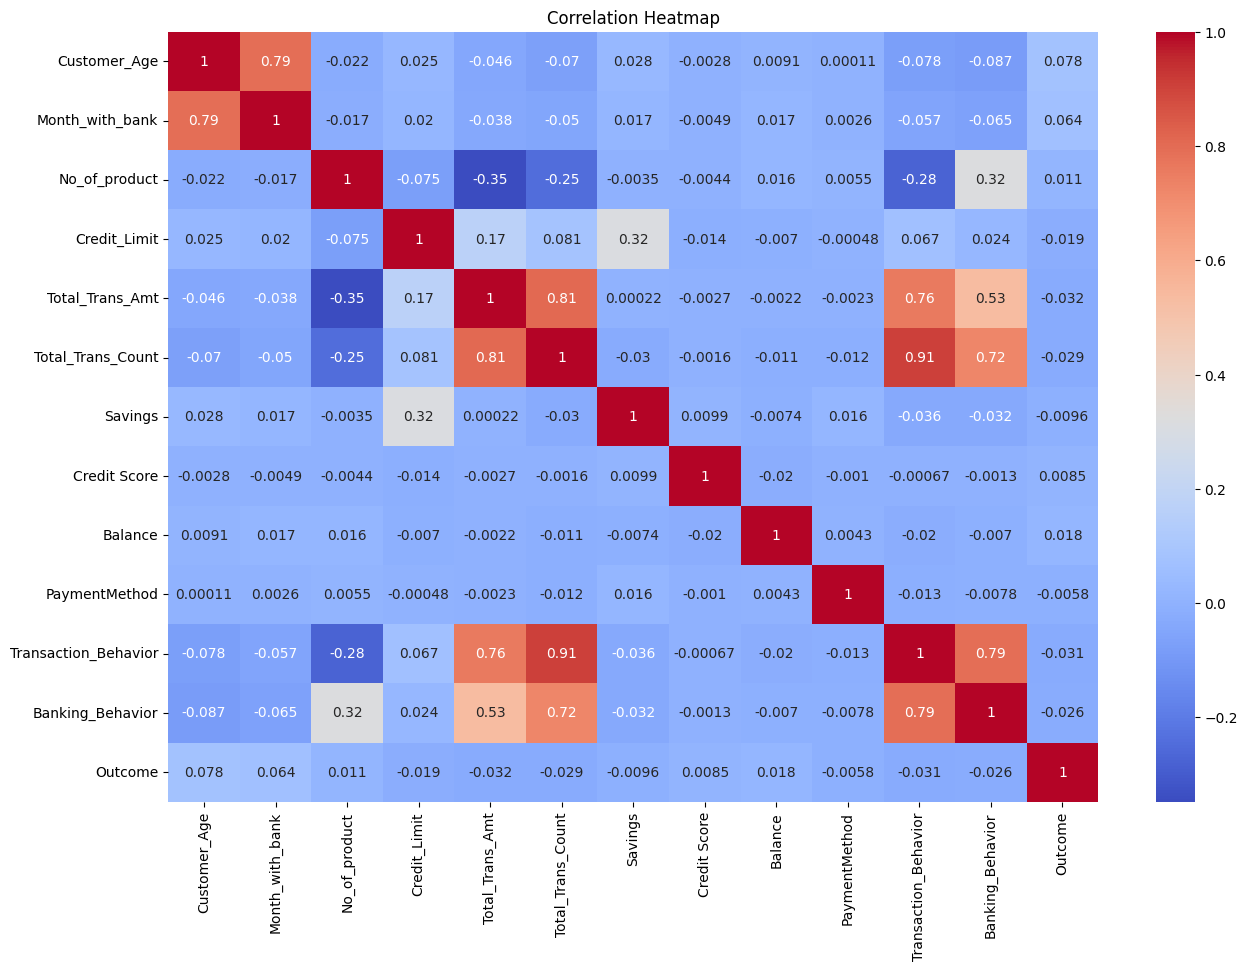

In [38]:
# Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(ori[num_cols_to_std].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Outcome does not have high correlation with most of the other variables. The highest positive correlation is with `Customer_Age`, followed by the `Month_with_bank`. This means that the campaign effectivness increases when targetting this campaign to older people.

In conclusion, correlation is not useful in finding the main drivers of engagement.

In [39]:
# converting categorical variables into numerical format
ori['Education_Level'] = ori['Education_Level'].replace({
    'Uneducated': 0,
    'High School': 1,
    'College': 2,
    'Graduate': 3,
    'Post-Graduate': 4,
    'Doctorate': 5
})

ori['Income_Category'] = ori['Income_Category'].map(
    {'120 +': 5, 
     '40 - 60': 4, 
     '60 - 80': 3, 
     '80 - 120': 2, 
     'Less than 40': 1})

ori['Card_Category'] = ori['Card_Category'].map(
    {'Blue': 1, 
     'Silver': 2,
     'Gold': 3,
     'Platinum': 4})

X = ori[['Last_Contacted', 'Num_of_Contacts_Made', 'Months_Inactive_12_mon', 'Customer_Age', 
         'Total_Trans_Count', 'Total_Trans_Amt', 'Savings', 'Education_Level', 'Credit Score',
         'Outstanding Loans', 'Balance']]
y = ori['Outcome']
y = (y >= 1).astype(int)

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=1)

In [40]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index = X.columns, columns = ["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Customer_Age,0.138704
Credit Score,0.123132
Outstanding Loans,0.122091
Total_Trans_Amt,0.121828
Balance,0.116709
Savings,0.105646
Total_Trans_Count,0.102761
Num_of_Contacts_Made,0.055567
Education_Level,0.043084
Months_Inactive_12_mon,0.037231


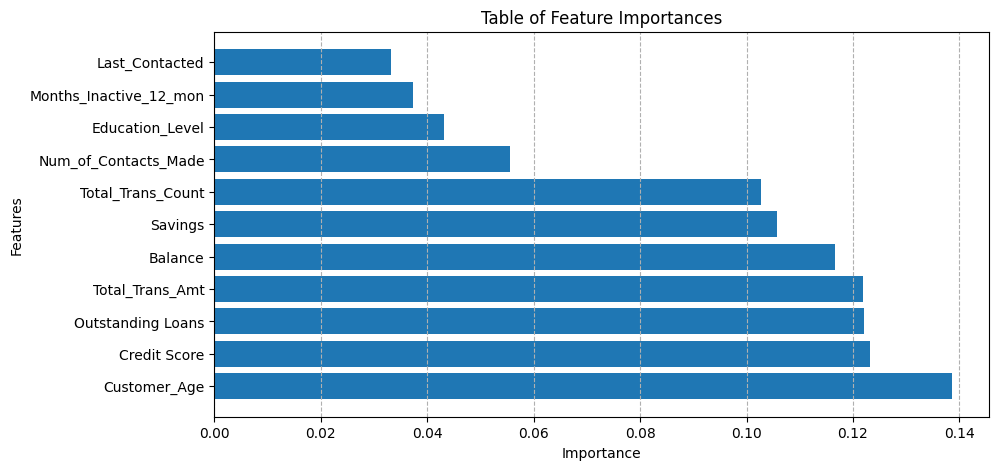

In [41]:
# Plotting the feature importances
plt.figure(figsize = (10, 5))
plt.title("Table of Feature Importances")
plt.barh(impt.index, impt["Importance"], align = "center")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(axis = 'x', linestyle = '--', alpha = 1)
plt.show()

- `Customer_Age` (0.137710) and `Outstanding Loans` (0.125297) are the most important features in this list.
- `Total_Trans_Count` (0.121587) and `Credit Score` (0.121351) follow, indicating moderate importance.
- The other features, like `Balance` (0.116552) and `Savings` (0.105837), are less important features but might still play a role.

### Propose metrics for tracking campaign effectiveness over time

##### Key Factors Influencing Customer Engagement
1) Customer Segmentation:
    - Digital Engagement Level: Customers who are highly digitally engaged (Segment 1) are more likely to respond positively to digital marketing campaigns through channels like emails, social media, or mobile apps. Low-engagement customers (Segment 3) might prefer more traditional outreach like direct mail.
    - Transaction History: High spenders/frequent users (Segment 4) are likely to engage more with promotions related to exclusive offers, loyalty programs, or high-end products. On the other hand, low spenders (Segment 6) might be motivated by discounts or cost-saving opportunities.
    - Financial Status: Customers with high financial standing (Segment 10) might be drawn to campaigns promoting investment opportunities, premium accounts, or wealth management services. Low financial standing customers (Segment 12) may engage more with campaigns focused on debt management, credit improvement, or lower-cost products.

2) Personalization:
    - Personalization is crucial across all segments. The more tailored a campaign is to a customer’s habits, needs, and preferences, the higher the likelihood of engagement. For instance, using customer data to send offers relevant to their transaction behavior, product usage, or financial status can greatly increase engagement.

3) Communication Channel:
    - Digital engagement levels directly influence the preferred channels for communication. Highly digitally engaged customers are more responsive to email, social media, or app notifications, while others may prefer direct mail or phone calls. 


##### Proposed Metrics for Tracking Campaign Effectiveness
1) Engagement Rate:
    - Tracks the overall interaction with campaigns (e.g., email opens, clicks). This is a key indicator of initial interest across all customer segments.
2) Conversion Rate:
    - Measures the percentage of customers who complete the desired action (e.g., purchase, sign-up), giving direct insight into campaign success.
3) Customer Lifetime Value (CLV):
    - Helps track long-term profitability and how successful campaigns are in retaining and increasing the value of customers over time.
4) Return on Marketing Investment (ROMI):
    - Shows the financial impact of campaigns by comparing revenue generated to campaign costs, ensuring resources are allocated efficiently.

## Optional Bonus Questions
## How can we predict and mitigate customer churn using machine learning techniques?

### Develop a machine learning model to predict the likelihood of customer churn.

In [42]:
original['Churn'] = original['Attrition_Flag'].apply(lambda x: 'No' if x == 'Existing Customer' else 'Yes')
ori = original.copy()
ori = ori.drop(columns = ['Attrition_Flag'])

In [43]:
total_customers = ori['Churn'].count()
churners = final_df[ori['Churn'] == 'Yes'].shape[0]
churn_rate = churners / total_customers * 100
print(f"The Churn Rate is quite high at {churn_rate:.2f}%.")

The Churn Rate is quite high at 15.72%.


### Likelihood of Churning for each customer

#### Preparing the data

In [44]:
np.random.seed(10)

# encoding 'Income_Category', 'Product_Usage', 'Cluster_Labels' and 'Churn' to numerical formats
encoders = {}
for c in ['Gender', 'Income_Category', 'Education_Level', 'Marital_Status', 'Product_Usage', 'Card_Category'
          , 'Cluster_Labels', 'Churn']:
    le = LabelEncoder()
    ori[c] = le.fit_transform(ori[c])
    encoders[c] = le

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X = ori.drop(columns = ['Churn'])
y = ori['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

#### Random Forest Classifier

To add Churn_Probability to the data.

In [45]:
model = RandomForestClassifier(random_state = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
churn_probabilities = model.predict_proba(X)[:, 1]

# add likelihood of a customer churning into the dataset
original['Churn_Probability'] = churn_probabilities

#### Testing viability

##### Accuracy and F1 scores

In [46]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.9393
F1 score: 0.7802


The accuracy is quite high at 93.60%. This shows that the model accurately classifies the customer into churned or not churned 93.60% of the time. However, this should not be trusted because most people did not churn (84.28%) in the data.

The F1 score is relatively high 77.18%. It is average of precision and recall and both of these contribute equally to the F1 score (Sharma, 2023). The model as a modest ability in predicting true positives (customers who actually churn). 

##### AUC - ROC 

AUC-ROC score: 0.9737


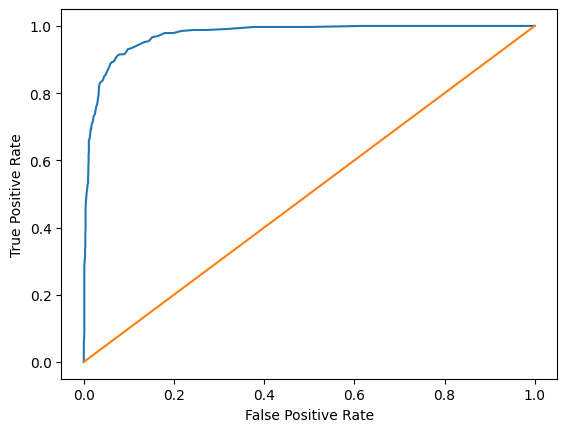

In [47]:
y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC score: {auc:.4f}")

# plotting the AUC-ROC
false_pos_r, true_pos_r, thresholds = roc_curve(y_test, y_prob)
plt.plot(false_pos_r, true_pos_r)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The AUC-ROC score is high at 97.14%. The model has significant in predicting the likelihood of a customer churning. The model correctly classifies with a probability of 97.14%.

### Early Warning System

In [49]:
print(final_df[['Credit Score', 'Outstanding Loans', 'Balance']].describe(percentiles=[.25, .5, .75, .9, .95]))

high_credit_risk_threshold = 469  #  25% quartile credit score
outstanding_loans_threshold = 35020  # 75% quartile outstanding loans
low_balance_threshold = 50000  # Low balance Threshold

# Create an alert column based on above risk criteria
final_df['Alert'] = final_df.apply(
    lambda row: 'High risk of churn - follow up needed' if (
        row['Credit Score'] < high_credit_risk_threshold and
        row['Outstanding Loans'] > outstanding_loans_threshold and
        row['Balance'] < low_balance_threshold
    ) else 'Low risk', axis=1
)

# Displaying the dataframe with Alert column
print(final_df[['CLIENTNUM', 'Credit Score', 'Outstanding Loans', 'Balance', 'Alert']])

risk_counts = final_df['Alert'].value_counts()
print(risk_counts) # 7019 low risk, 62 high risk

       Credit Score  Outstanding Loans        Balance
count   7081.000000        7081.000000    7081.000000
mean     574.743779       25447.067782  125045.433675
std      157.516397       14094.368816   72440.788954
min       37.165633      -28669.303366 -131243.665523
25%      469.224912       15709.673670   74794.430592
50%      574.247358       25552.586222  125930.249488
75%      679.615117       35020.914430  173856.713644
90%      777.733924       43439.897805  218298.194889
95%      831.057422       49103.289089  243754.462623
max     1151.077626       75094.796212  391330.688803
      CLIENTNUM  Credit Score  Outstanding Loans        Balance     Alert
0     768805383    557.296785       44151.310980  116975.197468  Low risk
1     818770008    346.521606      -12075.959276  195558.507842  Low risk
2     713982108    741.653188       40365.516111   90595.445690  Low risk
3     709106358    594.303626       40175.503771  128835.057040  Low risk
4     713061558    542.969065       

### Retention Strategies

#####
1. Personalized Communication
Targeted Messaging: Use customer data to send tailored emails that acknowledge individual preferences and behaviors. Highlight relevant promotions or services to create a more personalized experience, which can significantly enhance engagement and satisfaction.

2. Incentives and Rewards
Loyalty Programs: Implement a rewards program that encourages continued use of your services. Offering points, discounts, or exclusive benefits can motivate high-risk customers to remain loyal and feel valued.

3. Enhanced Customer Support
Dedicated Account Management: Assign dedicated account managers to high-risk customers. This personalized support ensures their concerns are addressed promptly and reinforces the commitment to customer satisfaction, fostering a stronger relationship and trust.